<font size="6"> **Analyze SEC 10-K Fillings** </font>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run ../nb_config.py

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy
import pickle

import os

from tqdm import tqdm

In [4]:
from src import utils
from src.load_data import io_utils
from src.mle_quant_utils import quant_factors

In [5]:
cfg = utils.read_conf()

In [6]:
INPATH1 = os.path.join(io_utils.interim_path, 'sec_fillings', '')
INPATH2 = os.path.join(io_utils.raw_path, 'market_data', cfg['quantopian']['dataset4']['folder'],'')
INPATH3 = os.path.join(io_utils.processed_path, 'sec_fillings', '')
os.path.isdir(INPATH1), os.path.isdir(INPATH2), os.path.isdir(INPATH3)

(True, True, True)

In [7]:
INFILE1 = 'metadata.pkl'
INFILE2 =  'parsed_sentiment_loughran_mcdonald.csv'
INFILE3 = cfg['quantopian']['dataset4']['prices']
INFILE4 = cfg['output']['interim']['pricing']
INFILE5 = cfg['output']['interim']['sector_factors']
INFILE6 = 'sec_10k_loughran_sent_alpha.csv'
INFILE7 = 'sec_10k_mlbow_sent_alpha.csv'

In [8]:
OUTPATH =  os.path.join(io_utils.processed_path, 'sec_fillings', '')
os.path.isdir(OUTPATH)

True

In [9]:
START_DT = '1998-01-01'
END_DT = '2017-12-31'

# Load Data

## Sentiments Metadata

In [10]:
sentiment_df =  pd.read_csv(INPATH1 + INFILE2)
sentiments = sentiment_df.columns.tolist()[:-1]
sentiments

['negative',
 'positive',
 'uncertainty',
 'litigious',
 'constraining',
 'interesting']

## Prices

In [11]:
# Yearly pricing
pricing_yr = pd.read_csv(INPATH2 + INFILE3, parse_dates=['date'])
pricing_yr = pricing_yr.pivot(index='date', columns='ticker', values='adj_close')[START_DT:]
pricing_yr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21 entries, 1998-01-01 to 2018-01-01
Columns: 11941 entries, A to ZZZ
dtypes: float64(11941)
memory usage: 1.9 MB


In [12]:
pd.concat([pricing_yr.head(2), pricing_yr.tail(2)], axis=0)

ticker,A,AA,AAAP,AABA,AAC,AADR,AAIT,AAL,AAMC,AAME,AAN,AAOI,AAON,AAP,AAPC,AAPL,AAT,AAU,AAV,AAVL,AAWW,AAXJ,AAXN,AA_P_B,AA_W,...,ZOES,ZOM,ZOOM,ZPIN,ZQK,ZROZ,ZS,ZSAN,ZSL,ZSML,ZSPH,ZTO,ZTR,ZTS,ZU,ZUMZ,ZUO,ZVZZC,ZVZZCNX,ZX,ZXYZ_A,ZYME,ZYNE,ZZK,ZZZ
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998-01-01,NaN,NaN,NaN,29.6125,NaN,NaN,NaN,NaN,NaN,4.543018,4.199306,NaN,0.701835,NaN,NaN,1.300324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.00,NaN,5.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.714852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-01,52.378553,NaN,NaN,108.1750,NaN,NaN,NaN,NaN,NaN,2.155487,5.142459,NaN,1.083688,NaN,NaN,3.265419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.44,NaN,3.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.671104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,66.653918,53.87,81.62,69.8500,9.00,58.835707,NaN,51.803585,81.6,3.378882,39.797356,37.82,36.522919,99.593649,10.6,167.901180,37.654925,1.03,4.3,NaN,58.65,75.858764,26.50,NaN,NaN,...,16.72,1.9771,NaN,18.2,NaN,120.593382,NaN,10.40,31.40,26.9,NaN,15.641173,12.643875,71.815333,NaN,20.825,NaN,100.1,NaN,1.2165,NaN,7.5931,12.52,25.0,0.01
2018-01-01,61.800000,46.88,81.63,73.3500,9.81,52.880000,NaN,37.990000,67.9,2.575000,43.740000,46.00,35.250000,135.860000,NaN,185.400000,38.860000,0.71,3.1,NaN,71.45,70.250000,64.98,NaN,NaN,...,10.16,2.2100,NaN,NaN,NaN,115.750000,36.67,4.68,34.91,NaN,NaN,19.450000,11.450000,86.150000,NaN,24.300,26.74,NaN,NaN,1.3800,NaN,15.3400,9.17,NaN,NaN


In [13]:
# Daily pricing
pricing = pd.read_csv(io_utils.interim_path + INFILE4, parse_dates=['date'], index_col='date')

pd.concat([pricing.head(2), pricing.tail(2)], axis=0)

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,...,WBA,WDC,WEC,WFC,WHR,WM,WMB,WMT,WRK,WU,WY,WYN,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-06,57.014,10.822,59.209,42.399,NaN,31.088,19.926,41.270,32.27,30.936,26.230,34.990,70.301,41.26,20.703,26.659,10.986,29.308,23.236,50.648,46.749,20.247,32.972,22.599,48.45,...,35.023,28.571,22.424,26.328,73.779,28.636,14.060,44.446,NaN,15.490,15.583,25.603,85.930,85.815,17.834,19.045,25.095,59.697,33.386,25.945,NaN,30.184,49.601,23.427,NaN
2011-01-07,57.495,10.976,60.790,42.702,NaN,31.150,20.009,41.338,32.04,30.756,26.445,35.070,70.026,40.76,20.703,26.555,10.986,29.371,23.145,51.440,47.314,20.088,32.596,22.458,48.69,...,34.814,28.589,22.594,25.796,73.468,28.479,14.283,44.545,NaN,15.346,16.011,25.509,88.972,87.296,17.993,19.010,24.954,60.023,33.251,25.583,NaN,30.560,49.592,23.182,NaN
2016-01-04,130.838,39.933,151.537,100.621,52.526,97.613,40.544,96.984,91.97,51.310,33.183,77.587,267.230,60.31,39.633,53.390,8.493,106.357,27.897,300.779,57.212,36.450,74.077,37.451,52.31,...,79.032,56.158,47.153,49.176,139.143,49.421,22.642,57.521,37.972,16.153,27.113,66.912,65.687,89.186,32.915,36.226,43.194,70.617,58.018,26.056,34.923,49.300,99.714,25.983,46.398
2016-01-05,131.369,39.552,150.502,98.100,52.307,99.041,40.534,97.489,92.34,50.933,33.553,77.776,269.531,60.39,40.103,53.829,8.611,107.837,27.859,302.012,57.410,37.378,75.313,37.553,52.02,...,76.958,55.916,47.659,49.157,136.146,49.610,22.720,58.887,37.947,16.089,27.177,67.441,66.929,89.761,33.247,36.302,43.836,71.218,59.201,26.005,34.913,49.177,101.790,25.701,47.124


## Sector Metadata

In [14]:
SECTOR_FOLDER = cfg['quantopian']['dataset1']['sector_folder']
SECTOR_NAMES = cfg['quantopian']['dataset1']['sector_names']

# Specify the bundle path
sector_file = os.path.join(io_utils.raw_path, 'market_data',SECTOR_FOLDER, SECTOR_NAMES)

In [15]:
sector_names = pd.read_csv(sector_file, usecols=['Sector', 'sector_id'], index_col='sector_id')
sector_names.loc[-1, 'Sector'] = 'No sector'
sector_names = sector_names.drop_duplicates()

sector_names

,Sector
sector_id,
0,Healthcare
1,Technology
2,Consumer Defensive
3,Industrials
4,Utilities
5,Financial Services
6,Real Estate
7,Communication Services
8,Consumer Cyclical


In [17]:
sector_factor_df = pd.read_csv(io_utils.interim_path + INFILE5, parse_dates=['date'], index_col=[0,1])

sector_factor_df = sector_factor_df.reset_index().merge(sector_names, how='left', left_on='sector_code', right_index=True).\
    set_index(keys=['date', 'asset'])[['sector_code', 'Sector']]
sector_factor_df.columns = ['sector_code', 'sector']

pd.concat([sector_factor_df.head(2), sector_factor_df.tail(2)], axis=0)

sector_code              sector
date       asset                                 
2013-01-03 A                0          Healthcare
           AAL              3         Industrials
2015-12-28 ZION             5  Financial Services
           ZTS              0          Healthcare

In [18]:
# Mapping from asset to sector (no date)
sector_to_asset = sector_factor_df.reset_index('asset').drop_duplicates().set_index('asset')

pd.concat([sector_to_asset.head(2), sector_to_asset.tail(2)], axis=0)

,sector_code,sector
asset,,
A,0,Healthcare
AAL,3,Industrials
HPE,1,Technology
CSRA,1,Technology


## NLP Alpha Factors

In [66]:
sent_alphas_lou = pd.read_csv(INPATH3+INFILE6, parse_dates=['date']).rename(columns={'date': 'date_filling'})

mask = sent_alphas_lou['date_filling'].between( pd.Timestamp(START_DT), pd.Timestamp(END_DT))
sent_alphas_lou = sent_alphas_lou.loc[mask].copy()

sent_alphas_lou['date'] = sent_alphas_lou['date_filling'].dt.year.apply(lambda x: dt.datetime(year=x, month=1, day=1))
date_filling = sent_alphas_lou['date_filling']

pd.concat([sent_alphas_lou.head(2), sent_alphas_lou.tail(2)], axis=0)

,ticker,date_filling,negative,positive,uncertainty,litigious,constraining,interesting,date
0,aal,2003-04-15,0.156000,-0.550589,0.523059,-0.954354,-1.624239,1.486592,2003-01-01
1,aal,2004-02-27,0.760193,-1.006005,0.696464,-0.268571,-1.042421,1.260921,2004-01-01
8632,zts,2016-02-24,0.919365,-1.020223,-0.694372,-1.206424,-0.329730,0.539205,2016-01-01
8633,zts,2017-02-16,1.069740,-1.556336,-0.606315,-0.227851,1.324624,-0.050204,2017-01-01


In [67]:
sent_alphas_mlbow = pd.read_csv(INPATH3+INFILE7, parse_dates=['date'])
splits = sent_alphas_mlbow.pop('split')
sent_alphas_mlbow = sent_alphas_mlbow[['date', 'ticker', 'sentiment_score']].rename(columns={'sentiment_score': 'ml_bow_sentiment'})

pd.concat([sent_alphas_mlbow.head(2), sent_alphas_mlbow.tail(2)], axis=0)

,date,ticker,ml_bow_sentiment
0,1998-01-01,abt,1.248166
1,1998-01-01,adbe,1.085362
7253,2017-01-01,zion,-0.675828
7254,2017-01-01,zts,1.455928


In [68]:
sent_alphas_lou.index.shape, sent_alphas_lou.index.drop_duplicates().shape

((7322,), (7322,))

In [69]:
sent_alphas_mlbow.index.shape, sent_alphas_mlbow.index.drop_duplicates().shape

((7255,), (7255,))

In [70]:
join_cols = ['date', 'ticker']
sent_alphas = sent_alphas_lou.merge(sent_alphas_mlbow, how='inner', on=join_cols)
sent_alphas['ticker'] = sent_alphas['ticker'].str.upper()
sent_alphas = sent_alphas.drop_duplicates(subset=join_cols)

sent_alphas_yr = sent_alphas.set_index(join_cols).sort_index()  # duplicated index entries are generated
sent_alphas = sent_alphas.set_index(['date_filling', 'ticker']).sort_index()

pd.concat([sent_alphas.head(2), sent_alphas.tail(2)], axis=0)

,,negative,positive,uncertainty,litigious,constraining,interesting,date,ml_bow_sentiment
date_filling,ticker,,,,,,,,
1998-01-21,ROP,0.202734,-0.255622,0.590575,0.044073,-1.278109,0.520066,1998-01-01,0.940647
1998-01-23,AMAT,1.189962,-1.683578,1.242852,1.630689,1.260480,-1.331016,1998-01-01,0.651217
2017-12-21,A,0.567696,-0.822580,-0.251022,0.544525,-0.668105,-1.602679,2017-01-01,1.695364
2017-12-22,COO,-1.185596,0.482735,1.054292,-0.598591,-0.119718,0.583143,2017-01-01,0.297365


In [71]:
pd.concat([sent_alphas_yr.head(2), sent_alphas_yr.tail(2)], axis=0)

date_filling  negative  positive  uncertainty  litigious  \
date       ticker                                                            
1998-01-01 ABT      1998-03-09  1.630689 -1.701207     1.295739   0.837381   
           ADBE     1998-02-17 -0.943155 -0.943156    -0.643462   0.572945   
2017-01-01 ZION     2017-02-28  0.057928  1.247386     0.490458  -0.490458   
           ZTS      2017-02-16  1.069740 -1.556336    -0.606315  -0.227851   

                   constraining  interesting  ml_bow_sentiment  
date       ticker                                               
1998-01-01 ABT         1.507287    -1.701232          1.248166  
           ADBE       -1.137076    -0.590583          1.085362  
2017-01-01 ZION        0.003862    -1.455928         -0.675828  
           ZTS         1.324624    -0.050204          1.455928

In [72]:
sent_alphas.index.shape, sent_alphas.index.drop_duplicates().shape

((7243,), (7243,))

# Create Alpha Factors

Clean and Compute Forward Returns

In [73]:
import alphalens as al

In [74]:
alpha_factors = sentiments + ['ml_bow_sentiment']

## Forward Returns

In [85]:
amzn_dates = pricing.loc[amzn_dates, 'AMZN'].loc['2011': '2015'].index
amzn_dates

DatetimeIndex(['2011-01-28', '2012-02-01', '2013-01-30', '2014-01-31',
               '2015-01-30'],
              dtype='datetime64[ns]', name='date_filling', freq=None)

In [105]:
pricing.loc[amzn_dates].sample(4)

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,...,WBA,WDC,WEC,WFC,WHR,WM,WMB,WMT,WRK,WU,WY,WYN,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date_filling,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-30,132.038,47.496,158.025,110.031,53.663,90.017,41.609,78.341,70.13,47.825,42.134,76.166,284.067,54.005,40.031,55.334,10.741,88.784,26.248,260.740,45.640,35.524,58.801,40.062,58.155,...,69.030,88.058,49.466,46.983,183.478,47.042,35.609,77.388,NaN,15.091,31.329,77.484,137.636,101.698,33.315,32.070,35.361,77.022,49.045,32.472,32.485,48.539,108.881,23.134,41.721
2011-01-28,57.371,9.782,62.962,42.700,NaN,32.105,18.901,43.876,32.49,31.337,27.116,34.910,70.075,39.970,20.784,26.452,10.462,30.093,23.617,52.339,37.102,19.810,33.305,23.128,47.751,...,35.057,29.376,23.232,26.074,75.509,29.784,15.246,46.703,NaN,15.793,17.646,24.098,85.810,96.416,17.872,19.603,26.802,62.723,34.258,23.885,NaN,28.781,55.240,22.106,NaN
2013-01-30,64.893,13.768,72.748,58.563,30.712,41.793,29.690,64.233,37.94,38.283,24.858,45.931,150.919,38.730,26.306,36.666,9.271,46.178,22.963,83.954,34.715,23.053,34.274,30.721,40.400,...,36.441,41.083,32.400,30.131,96.551,30.776,26.235,60.485,NaN,11.822,24.625,49.708,106.211,62.074,22.585,24.810,32.009,75.618,40.678,19.269,25.812,41.399,70.971,22.302,NaN
2012-02-01,64.017,8.569,75.599,57.957,NaN,35.932,22.942,50.738,31.24,33.064,24.673,41.224,109.179,37.000,24.461,30.576,10.961,41.804,20.528,57.745,24.513,20.131,35.282,27.937,32.009,...,29.478,32.916,27.394,24.998,53.304,28.626,20.995,52.630,NaN,15.621,16.105,35.345,93.119,56.547,21.034,18.360,30.894,68.285,36.793,17.958,24.381,40.602,57.381,16.092,NaN


In [116]:
fwd_rets_2011 = al.utils.get_clean_factor_and_forward_returns(
     factor=sent_alphas.loc['2011', 'positive'],
     prices=pricing.loc['2011-01': '2012-01'], quantiles=5, bins=None, periods=[20])

Dropped 11.2% entries from factor data: 0.2% in forward returns computation and 11.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [129]:
p0, p1 = pricing.loc['2011-01-28', 'AMZN'], pricing.shift(-20).loc['2011-01-28', 'AMZN']
ret = (p1-p0) /p0 
print(p0, p1, ret)

171.14 173.29 0.012562814070351792


In [130]:
np.isclose(ret, fwd_rets_2011.xs(key='AMZN', level='asset')['20D'])

array([ True])

In [143]:
factor_data_yr, factor_data_5d, factor_data_20d = {}, {}, {}
skipped_sentiments = []

for alpha in alpha_factors:

    try:
        data_yr = al.utils.get_clean_factor_and_forward_returns(
            sent_alphas_yr[alpha], pricing_yr, quantiles=5, bins=None, periods=[1])
        
        data_5d = al.utils.get_clean_factor_and_forward_returns(
            sent_alphas[alpha], pricing, quantiles=5, bins=None, periods=[5],
            max_loss=0.9)  #max loss is increase due to factor sparsity
            
        data_20d = al.utils.get_clean_factor_and_forward_returns(
            sent_alphas[alpha], pricing, quantiles=5, bins=None, periods=[20],
            max_loss=0.9  #max loss is increase due to factor sparsity
        )
        factor_data_yr[alpha] = data_yr
        factor_data_5d[alpha] = data_5d
        factor_data_20d[alpha] = data_20d
    except:
        skipped_sentiments.append(alpha)

if skipped_sentiments:
    print('\nSkipped the following sentiments:\n{}'.format('\n'.join(skipped_sentiments)))

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 73.7% entries from factor data: 70.4% in forward returns computation and 3.3% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 90.0%, not exceeded: OK!
Dropped 73.8% entries from factor data: 70.5% in forward returns computation and 3.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 90.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 73.7% entries from factor data: 70.4% in forward returns computation and 3.3% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 90.0%, not exceeded: OK!
Dropped 7

In [144]:
factor_data['negative'].index.shape

(1900,)

In [145]:
factor_data['negative'].index.drop_duplicates().shape

(1900,)

## Alpha Factors Assessment

In [146]:
df_factor_return_yr, df_sharpe_yr, df_rank_ic_yr, df_fra_yr, df_qr_yr = quant_factors.factor_evaluation(
    factor_data_yr, factor_names=alpha_factors, frequency="daily")

Calculating the factor weighted returns and sharpe-ratio for: negative
Calculating the Ranked IC for: negative
Calculating the FRA for: negative
Calculating Quantile returns for: negative
Calculating the factor weighted returns and sharpe-ratio for: positive
Calculating the Ranked IC for: positive
Calculating the FRA for: positive
Calculating Quantile returns for: positive
Calculating the factor weighted returns and sharpe-ratio for: uncertainty
Calculating the Ranked IC for: uncertainty
Calculating the FRA for: uncertainty
Calculating Quantile returns for: uncertainty
Calculating the factor weighted returns and sharpe-ratio for: litigious
Calculating the Ranked IC for: litigious
Calculating the FRA for: litigious
Calculating Quantile returns for: litigious
Calculating the factor weighted returns and sharpe-ratio for: constraining
Calculating the Ranked IC for: constraining
Calculating the FRA for: constraining
Calculating Quantile returns for: constraining
Calculating the factor weigh

In [147]:
df_factor_return_5d, df_sharpe_5d, df_rank_ic_5d, df_fra_5d, df_qr_5d = quant_factors.factor_evaluation(
    factor_data_5d, factor_names=alpha_factors, frequency="daily")

Calculating the factor weighted returns and sharpe-ratio for: negative
Calculating the Ranked IC for: negative
Calculating the FRA for: negative
Calculating Quantile returns for: negative
Calculating the factor weighted returns and sharpe-ratio for: positive
Calculating the Ranked IC for: positive
Calculating the FRA for: positive
Calculating Quantile returns for: positive
Calculating the factor weighted returns and sharpe-ratio for: uncertainty
Calculating the Ranked IC for: uncertainty
Calculating the FRA for: uncertainty
Calculating Quantile returns for: uncertainty
Calculating the factor weighted returns and sharpe-ratio for: litigious
Calculating the Ranked IC for: litigious
Calculating the FRA for: litigious
Calculating Quantile returns for: litigious
Calculating the factor weighted returns and sharpe-ratio for: constraining
Calculating the Ranked IC for: constraining
Calculating the FRA for: constraining
Calculating Quantile returns for: constraining
Calculating the factor weigh

In [149]:
df_factor_return_20d, df_sharpe_20d, df_rank_ic_20d, df_fra_20d, df_qr_20d = quant_factors.factor_evaluation(
    factor_data_20d, factor_names=alpha_factors, frequency="daily")

Calculating the factor weighted returns and sharpe-ratio for: negative
Calculating the Ranked IC for: negative
Calculating the FRA for: negative
Calculating Quantile returns for: negative
Calculating the factor weighted returns and sharpe-ratio for: positive
Calculating the Ranked IC for: positive
Calculating the FRA for: positive
Calculating Quantile returns for: positive
Calculating the factor weighted returns and sharpe-ratio for: uncertainty
Calculating the Ranked IC for: uncertainty
Calculating the FRA for: uncertainty
Calculating Quantile returns for: uncertainty
Calculating the factor weighted returns and sharpe-ratio for: litigious
Calculating the Ranked IC for: litigious
Calculating the FRA for: litigious
Calculating Quantile returns for: litigious
Calculating the factor weighted returns and sharpe-ratio for: constraining
Calculating the Ranked IC for: constraining
Calculating the FRA for: constraining
Calculating Quantile returns for: constraining
Calculating the factor weigh

## Sharpe Ratio

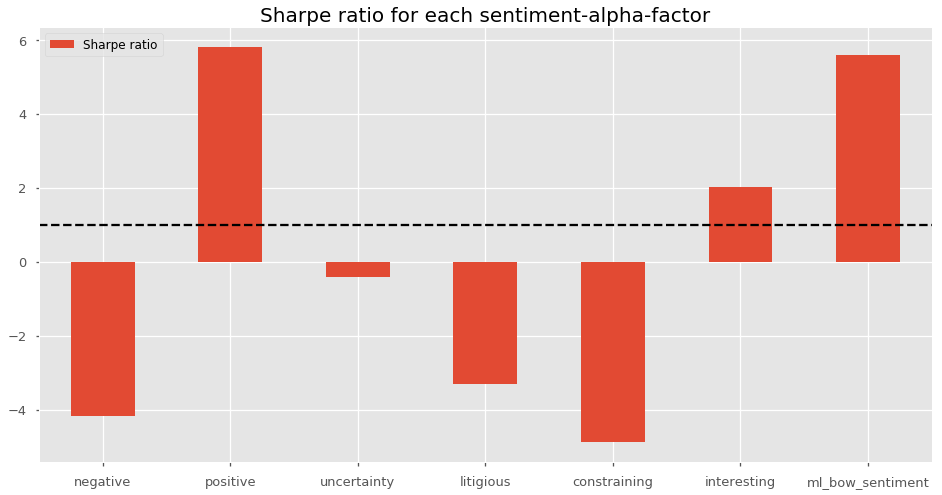

In [150]:
df_sharpe_yr.plot.bar( figsize=(16,8))
plt.title('Sharpe ratio for each sentiment-alpha-factor')
plt.axhline(y=1, linestyle='--', color='black')
plt.xticks(rotation=0)
plt.show()

In [157]:
df_sharpe_5d.join(df_sharpe_20d, lsuffix=' 5d', rsuffix='20d')

,Sharpe ratio 5d,Sharpe ratio20d
negative,0.535756,0.892216
positive,0.966485,0.234434
uncertainty,-0.917421,-0.256151
litigious,-0.595750,1.108748
constraining,2.559805,2.239078
interesting,-0.708322,-0.171307
ml_bow_sentiment,1.619838,0.796714


## Forward Returns

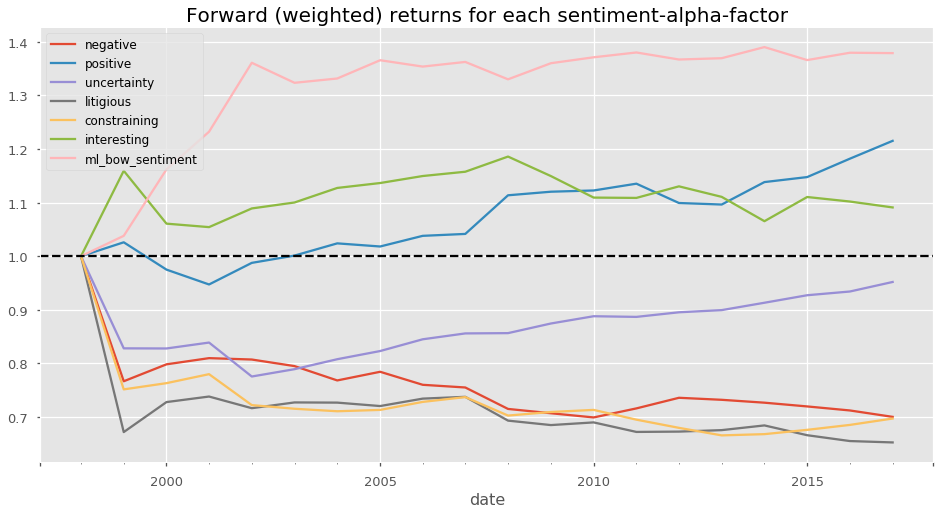

In [159]:
fwd_rets_yr = (1 + df_factor_return_yr).cumprod()
fwd_rets_yr.iloc[0] = 1
fwd_rets_yr.plot( figsize=(16,8))
plt.title('Forward (weighted) returns for each sentiment-alpha-factor')
plt.axhline(y=1, linestyle='--', color='black', )
plt.show()

## Information Coefficient

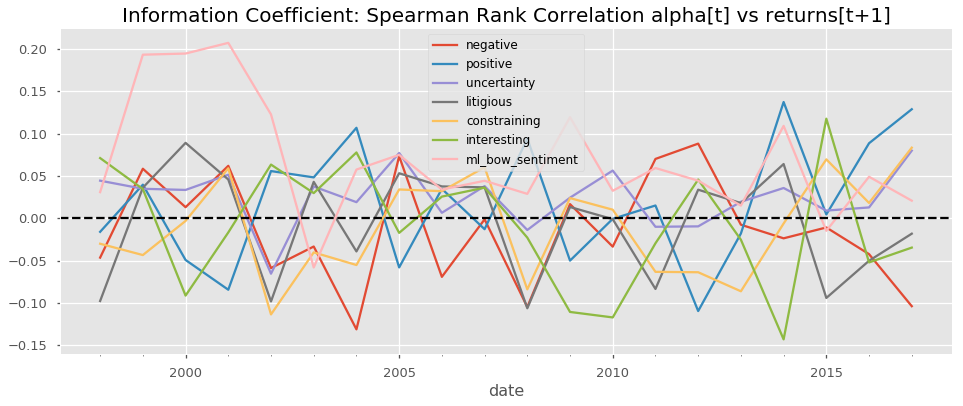

In [160]:
df_rank_ic_yr.plot(figsize=(16, 6))
plt.title('Information Coefficient: Spearman Rank Correlation alpha[t] vs returns[t+1]')
plt.axhline(y=0, linestyle='--', color='black', )
plt.show()

In [163]:
df_rank_ic_yr.mean(axis=0)

negative           -0.014350
positive            0.017656
uncertainty         0.023962
litigious          -0.005994
constraining       -0.010028
interesting        -0.008038
ml_bow_sentiment    0.068138
dtype: float64

## Quantile Analysis

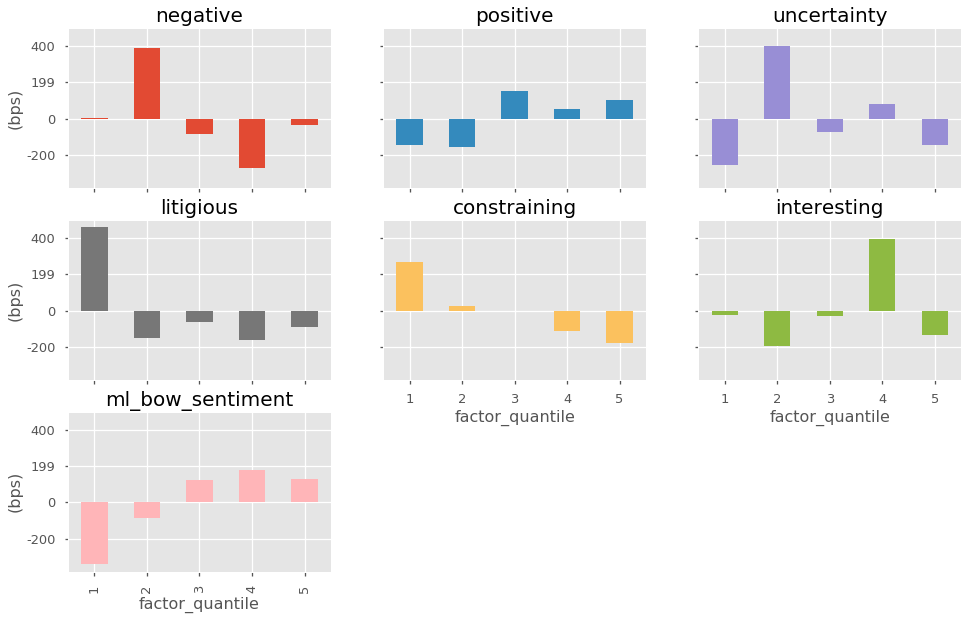

In [161]:
axs = df_qr_yr.plot.bar(subplots=True, layout=(3,3), legend=False, sharex=True, sharey=True,  figsize=(16, 10))
plt.title('Quantile Analysis: Forward Returns Average by sentiment-alpha-factor quantile')

for ax in axs[1,:]:
    ax.tick_params(labelrotation=0)
for ax in axs[:,0]:
    ax.set_yticklabels([int(x) for x in ax.get_yticks()*1e4])
    ax.set_ylabel("(bps)")
plt.show()

## Turnover (FRA)

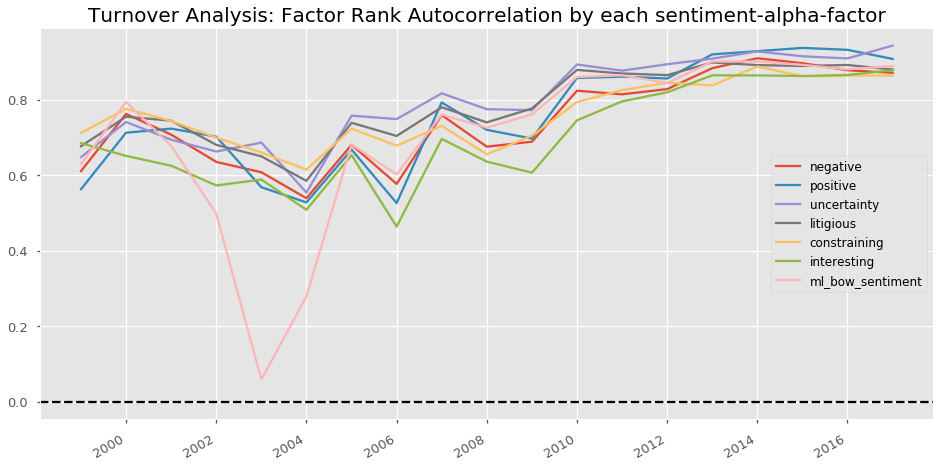

In [162]:
df_fra_yr[START_DT:].plot(title="Factor Rank Autocorrelation", figsize=(16,8))
plt.title('Turnover Analysis: Factor Rank Autocorrelation by each sentiment-alpha-factor')
plt.axhline(y=0, linestyle='--', color='black', )
plt.show()